### This file is for visualization of the porposed model, inclucing learned motifs by the model, computing t-SNE in 2D plot, and mutation visualization

In [1]:
from keras import backend as K
import tensorflow as tf
from keras import initializers,layers,regularizers
from keras.layers import Dropout
from keras import callbacks
from keras.models import *
from keras.engine.topology import Layer
from keras.callbacks import EarlyStopping
from keras.layers import Dropout,Activation
import numpy as np
from keras import optimizers
from Bio import SeqIO
from sklearn.model_selection import train_test_split
import keras
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from scipy import interp
from keras.regularizers import l2
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU,BatchNormalization,Concatenate
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [2]:
def onehot(seq):
    bases = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    X = np.zeros((len(seq),len(seq[0]),len(bases)))
    for i,m in enumerate(seq):
        for l,s in enumerate(m):
    #         print(s)
            if s in bases:
                X[i,l,bases.index(s)] = 1
    return X

In [3]:
def read_fasta(file_path):
    '''File_path: Path to the fasta file
       Returns: List of sequence
    '''
    one=list(SeqIO.parse(file_path,'fasta'))
    return one

In [4]:
positive_data=read_fasta('pos_fasta_lysine.txt')
negative_data=read_fasta('neg_fasta_lysine.txt')
data_pure=positive_data+negative_data # this will be used in mutation analysis 

In [5]:
one_hot_positive=onehot(positive_data)
one_hot_negative=onehot(negative_data)

In [6]:
training_data=np.concatenate((one_hot_positive,one_hot_negative),axis=0)

### label the data for t-sne visualization

In [7]:
training_label=one_hot_positive.shape[0]*[[0,1]]+one_hot_negative.shape[0]*[[1,0]]
training_label=np.asarray(training_label)

In [8]:
class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """

    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

In [9]:
def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

In [10]:
class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """

    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(
            shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
            initializer=self.kernel_initializer,
            name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """
        # Begin: inputs_hat computation V1 ---------------------------------------------------------------------#
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # w_tiled.shape = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        # End: inputs_hat computation V1 ---------------------------------------------------------------------#
        """

        # Begin: inputs_hat computation V2 ---------------------------------------------------------------------#
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0. This is faster but requires Tensorflow.
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        # End: inputs_hat computation V2 ---------------------------------------------------------------------#
        """
        # Begin: routing algorithm V1, dynamic ------------------------------------------------------------#
        def body(i, b, outputs):
            c = tf.nn.softmax(b, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
            if i != 1:
                b = b + K.sum(inputs_hat * outputs, -1, keepdims=True)
            return [i-1, b, outputs]
        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), self.bias, K.sum(inputs_hat, 1, keepdims=True)]
        shape_invariants = [tf.TensorShape([]),
                            tf.TensorShape([None, self.input_num_capsule, self.num_capsule, 1, 1]),
                            tf.TensorShape([None, 1, self.num_capsule, 1, self.dim_vector])]
        _, _, outputs = tf.while_loop(cond, body, loop_vars, shape_invariants)
        # End: routing algorithm V1, dynamic ------------------------------------------------------------#
        """

        # Begin: routing algorithm V2, static -----------------------------------------------------------#
        # Routing algorithm V2. Use iteration. V2 and V1 both work without much difference on performance
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)
            
            # dim=2 is the num_capsule dimension
            # outputs.shape=[None, 1, num_capsule, 1, dim_vector]
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
                # tf.summary.histogram('BigBee', self.bias)  # for debugging
        # End: routing algorithm V2, static ------------------------------------------------------------#

        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])


# In[13]:


def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv1D(filters=dim_vector * n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv1d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)


# In[14]:


def CapsNet(input_shape, n_class, num_routing):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    
    x = layers.Input(shape=input_shape)
    #conv1=Bidirectional(GRU(gru_len, activation='relu', dropout=dropout_p, recurrent_dropout=dropout_p, return_sequences=True))(x)
    conv1 = layers.Conv1D(filters=32, kernel_size=7, strides=1, padding='valid', activation='relu', name='conv1')(x)
    conv1=Dropout(0.7)(conv1)
    lstm = layers.LSTM(units=128,   name='Lstm',  return_sequences=True)(conv1)
    # Layer 2: Conv1D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(lstm, dim_vector=8, n_channels=16, kernel_size=3, strides=1, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    KcrCaps = CapsuleLayer(num_capsule=n_class, dim_vector=8, num_routing=num_routing, name='KcrCaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out = Length(name='capsnet')(KcrCaps)
    #model
    train_model = Model(x, out)
    return train_model


In [11]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [12]:
mode1= CapsNet(input_shape=(31,20),n_class=2,num_routing=3)
mode1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
dim is deprecated, use axis instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 31, 20)            0         
_________________________________________________________________
conv1 (Conv1D)               (None, 25, 32)            4512      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 32)            0         
_________________________________________________________________
Lstm (LSTM)                  (None, 25, 128)           82432     
_________________________________________________________________
primarycap_conv1d (Conv1D)   (None, 23, 128)           49280     
________________________

### motifs visualization

In [13]:
mode1.load_weights('1Lastepoch_new.h5') # upload a model weight from  from the foldar 'five_fold_model_weights' in DeepCap-Kcr(https://github.com/Jhabindra-bioinfo/DeepCap-Kcr) resporatiory in github 

In [14]:
for layers in mode1.layers:
    print(layers.name)

input_1
conv1
dropout_1
Lstm
primarycap_conv1d
primarycap_reshape
primarycap_squash
KcrCaps
capsnet


In [15]:
f_conv_1D=K.function([mode1.input],[mode1.layers[1].output]) # conv 1 layer
f_lstm=K.function([mode1.input],[mode1.layers[3].output])#Lstm layer
f_primary_conv1D=K.function([mode1.input],[mode1.layers[4].output])#primary caps
capsules=K.function([mode1.input],[mode1.layers[6].output]) 

In [16]:
positive_ind_data=read_fasta('pos_ind_testdata.txt')
negative_ind_data=read_fasta('neg_ind_testdata.txt')
visu_data=positive_ind_data+negative_ind_data
all_ind_onehot=onehot(visu_data)

In [17]:
prediction=np.argmax(mode1.predict(all_ind_onehot),axis=1)

In [18]:
positive_prediction=[x for i,x in enumerate(all_ind_onehot) if prediction[i]==1]
positive_vis_data=[x for i,x in enumerate(visu_data) if prediction[i]==1]

In [19]:
all_positive_onehot=np.asarray(positive_prediction)

In [20]:
first_conv1d_output=f_conv_1D([all_positive_onehot])
lstm_outputs=f_lstm([all_positive_onehot])
primary_conv1D_outputs=f_primary_conv1D([all_positive_onehot])
capsules_outputs=capsules([all_positive_onehot])

In [21]:
first_conv_seq=[]
for seq in positive_vis_data:
    temp=[]
    for i in range(len(seq)-7+1):
        temp.append(seq[i:i+7].seq)
    first_conv_seq.append(temp)
temp_array=np.asarray(first_conv_seq)

In [22]:
print(first_conv_seq[0])

[Seq('LEKELFR', SingleLetterAlphabet()), Seq('EKELFRE', SingleLetterAlphabet()), Seq('KELFREM', SingleLetterAlphabet()), Seq('ELFREME', SingleLetterAlphabet()), Seq('LFREMES', SingleLetterAlphabet()), Seq('FREMESI', SingleLetterAlphabet()), Seq('REMESIL', SingleLetterAlphabet()), Seq('EMESILQ', SingleLetterAlphabet()), Seq('MESILQN', SingleLetterAlphabet()), Seq('ESILQNK', SingleLetterAlphabet()), Seq('SILQNKH', SingleLetterAlphabet()), Seq('ILQNKHL', SingleLetterAlphabet()), Seq('LQNKHLD', SingleLetterAlphabet()), Seq('QNKHLDV', SingleLetterAlphabet()), Seq('NKHLDVE', SingleLetterAlphabet()), Seq('KHLDVEK', SingleLetterAlphabet()), Seq('HLDVEKI', SingleLetterAlphabet()), Seq('LDVEKIV', SingleLetterAlphabet()), Seq('DVEKIVN', SingleLetterAlphabet()), Seq('VEKIVNL', SingleLetterAlphabet()), Seq('EKIVNLF', SingleLetterAlphabet()), Seq('KIVNLFP', SingleLetterAlphabet()), Seq('IVNLFPQ', SingleLetterAlphabet()), Seq('VNLFPQC', SingleLetterAlphabet()), Seq('NLFPQCT', SingleLetterAlphabet())]

In [23]:
def get_values(layer_output,num_of_output_channel,output_size):
    values=np.zeros((len(layer_output[0]),output_size,num_of_output_channel,1))
    for i in range(len(layer_output[0])):
        arg_max=np.argmax(layer_output[0][i,:,:],axis=1)
        max_val=np.max(layer_output[0][i,:,:],axis=1)
        for j,val in enumerate(arg_max):
            values[i,j,val,0]+=max_val[j]
    return values

In [24]:
def get_mottifs(values,filter_size,data,num_of_filters,threshold=None):
    motiffs={}
    temp=[]
    for x in range(len(data)):
        temp1=[]
        for i in range(len(data[0])-filter_size+1):
            temp2=[]
            for j in range(num_of_filters):
                if threshold:
                    if values[x,i,j,0]>=threshold:
                        if j in motiffs.keys():
                            if type(data[x]) is not list:
                                motiffs[j].append(data[x].seq[i:i+filter_size])
                            else:
                                motiffs[j].append(''.join([str(x) for x in data[x][i:i+filter_size]]))
                        else:
                            if type(data[x]) is not list:
                                motiffs[j]=[data[x].seq[i:i+filter_size]]
                            else:
                                motiffs[j]=[''.join([str(x) for x in data[x][i:i+filter_size]])]
                else:
                    temp_mottifs=''.join([str(x) for x in data[x][i:i+filter_size]])
                    temp2.append(temp_mottifs)
            temp1.append(temp2)
        temp.append(temp1)
    if threshold:
        return motiffs
    else:
        return temp

In [25]:
mottifs_conv1=get_mottifs(get_values(first_conv1d_output,32,25),7,positive_vis_data,32,0.5)

In [26]:
mottifs_lstm=get_mottifs(get_values(lstm_outputs,128,25),7,positive_vis_data,128,0.3)

In [27]:
mottifs_primary_conv2=get_mottifs(get_values(primary_conv1D_outputs,128,23),3,first_conv_seq,128,0.3)

### get motifs file for each capsule in Kcr caps

In [28]:
def get_capsule_mottifs(layer_output,sequence,threshold=None):
    mottifs={}
    max_index=np.argmax(layer_output[0],axis=-1)
    h,w,d=layer_output[0].shape
    for i in range(h):
        for j in range(w):
            if threshold:
                if layer_output[0][i,j,max_index[i,j]]>threshold:
                    if j in mottifs.keys():
                        mottifs[j].append(sequence[i,j,max_index[i,j]])
                    else:
                        mottifs[j]=[sequence[i,j,max_index[i,j]]]
            else:
                if j in mottifs.keys():
                        mottifs[j].append(sequence[i,j,max_index[i,j]])
                else:
                    mottifs[j]=[sequence[i,j,max_index[i,j]]]
    return mottifs

### sequence captured by each capsule with threshold 0.5

In [29]:
capsule_mottifs=get_capsule_mottifs(capsules_outputs,np.reshape(np.asarray(get_mottifs(get_values(primary_conv1D_outputs,128,23),3,first_conv_seq,128)),(-1,368,8)),threshold=0.5)

### By settting threshold of 0.5 the learned sequence by some of capsules (noted that total capsule used in the model were 368) 

In [30]:
capsule_mottifs.keys()

dict_keys([109, 125, 141, 157, 173, 189, 205, 221, 237, 253, 266, 269, 282, 285, 298, 301, 314, 317, 330, 333, 346, 349, 362, 365, 234, 74, 90, 106, 108, 122, 124, 138, 140, 154, 156, 170, 172, 186, 188, 202, 204, 218, 250, 357, 364, 61, 77, 93, 350, 366, 26, 225, 338, 354, 293, 300, 309, 316, 325, 332, 348, 289, 305, 321, 337, 353, 58, 241, 257, 273, 206, 222, 238, 284, 290, 306, 322, 334, 318, 254, 270, 280, 296, 303, 312, 319, 328, 335, 341, 344, 220, 94, 110, 126, 286, 302, 42, 360, 252, 268, 277, 261, 245, 29, 45, 92, 165, 78, 274, 358, 351, 367, 142, 158, 174, 209, 76, 197, 177, 60, 44, 97, 113, 229, 249, 264, 265, 281, 287, 297, 313, 329, 345, 361, 81, 136, 152, 168, 190, 236, 193, 271, 340, 356, 248, 10, 143, 161, 213, 54, 70, 86, 120, 255, 181, 145, 310, 326, 342, 294, 232, 149, 46, 62, 63, 129, 327, 343, 359, 239])

### save sequence file in fasta format, divided with length of 7

In [ ]:
for keys in capsule_mottifs.keys():
    f=open('capsule_new_motif/Caplsule'+str(keys)+'.txt',"w") # make your own file path to save to sequence for motifs
    for i,seq in enumerate(capsule_mottifs[keys]):
        f.write(">>"+str(i)+'0\n')
        f.write(str(seq[:7])+'\n')
        f.write(">>"+str(i)+'1\n')
        f.write(str(seq[7:14])+'\n')
        f.write(">>"+str(i)+'2\n')
        f.write(str(seq[14::])+'\n')
    f.close()

### an example,,sequences captured by capsule number 312

In [34]:
capsule_mottifs[312]

['ARSRPQFRSRPQFRSRPQFRG',
 'DRIKRAFRIKRAFLIKRAFLI',
 'KQKTKTIQKTKTIRKTKTIRS',
 'RNRRIFGNRRIFGLRRIFGLL',
 'DRKRKQERKRKQEEKRKQEEQ',
 'RVRRAGYVRRAGYARRAGYAY',
 'QRKKGKKRKKGKKKKKGKKKG',
 'KRKTRHSRKTRHSSKTRHSSN',
 'IRVVRKSRVVRKSIVVRKSIA',
 'KGRKGGTGRKGGTKRKGGTKG',
 'KKPEVKKKPEVKKVPEVKKVE',
 'ERLKRLQRLKRLQKLKRLQKS',
 'DKKRERRKKRERRKKRERRKK',
 'REKMLAAEKMLAAKKMLAAKS',
 'LRLKKQMRLKKQMRLKKQMRV',
 'HRKIGKERKIGKEQKIGKEQE',
 'RERRKKQERRKKQKRRKKQKL',
 'KRRRMLSRRRMLSSRRMLSSS',
 'LERERKKERERKKARERKKAL',
 'LARRFDRARRFDRKRRFDRKA',
 'KAIKKRGAIKKRGDIKKRGDY',
 'QREKKKEREKKKELEKKKELE',
 'RRRSIGNRRSIGNIRSIGNIK',
 'TGKRKKKGKRKKKAKRKKKAW',
 'LSLKRRGSLKRRGSLKRRGSK',
 'RTRPRNGTRPRNGTRPRNGTL',
 'KSRVKVKSRVKVKVRVKVKVR',
 'VTRNPRKTRNPRKKRNPRKKA',
 'ENKTLKRNKTLKRIKTLKRIS',
 'SKKPREMKKPREMKKPREMKG',
 'LREKERKREKERKKEKERKKE',
 'YRRRLLSRRRLLSVRRLLSVN',
 'RKRREEKKRREEKLRREEKLL',
 'ASQKVTKSQKVTKKQKVTKKT',
 'AHGRRKPHGRRKPQGRRKPQI',
 'LEEYKRKEEYKRKLEYKRKLA',
 'EEKQRLSEKQRLSRKQRLSRK',
 'ERKRRQKRKRRQKHKRRQKHQ',
 'YRRSRSLRRS

# mutagenesis analysis

In [14]:
def onehot2(seq):
    bases = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    X = np.zeros((len(seq),len(bases)))
    for i,m in enumerate(seq):
        if m in bases:
            X[i,bases.index(m)] = 1
    return X



In [15]:
input_ref_seq = onehot2(data_pure[0]) # use pure data with A C D....... given above
np.shape(input_ref_seq)


(31, 20)

In [16]:
nts= ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

mutation = np.zeros((len((data_pure)),31,20)) # x_train is your original sequence (In ACGT Form)

for k, seq in enumerate((data_pure)):
    orig = seq
    input_ref_seq = onehot2(seq)  # seq is your onehot encoded form of sequence
    input_ref_seq = np.expand_dims(input_ref_seq,axis=0)
    pred_y =  mode1.predict(input_ref_seq)
    #ref_pred=np.argmax(pred_y,axis=1
   # ref_pred = mode1.predict(input_ref_seq)[0][0]
    
    
    
    for i in range(31):
        for j, nt in enumerate(nts):
            txt = list(orig)
            txt[i]=nt
            #print(alt_seq)
            
            #alt_seq[i]= nt
            alt_seq = ''.join(txt)
            input_alt_seq = onehot2(alt_seq)
            input_alt_seq = np.expand_dims(input_alt_seq,axis=0)
            alt_pred= mode1.predict(input_alt_seq)
            diff = abs(pred_y[0][1] - alt_pred[0][1])  # you may try the absolute differences
            mutation[k,i,j] = diff
            alt_seq=''



In [32]:
mutagenesis = np.average(mutation,axis=0)

In [33]:
np.save('mutagenesis_new',mutagenesis)


In [34]:
mutagenesis=np.load('mutagenesis_new.npy')

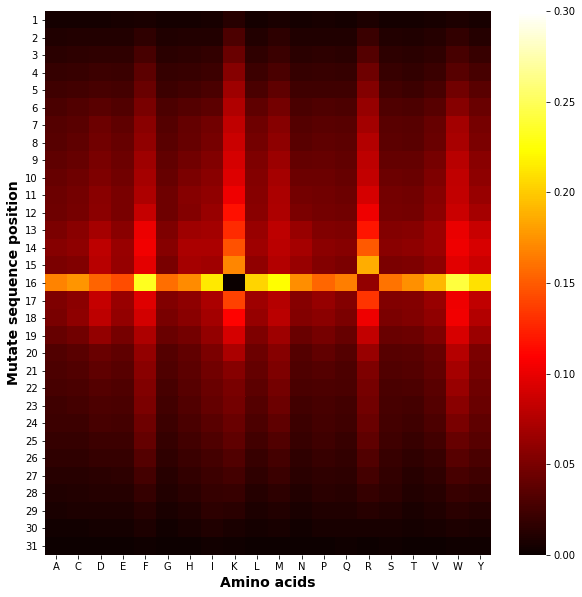

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#mutagenesis = np.load('mutagenesis.npy')
grid_kws = {"height_ratios": (.9, .08), "hspace": .3}

#flights_df = flight.pivot('Sequence', 'Nucleotides') 

x_axis_labels = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'] # labels for x-axis
y_axis_labels = np.arange(1,32,step=1) # labels for y-axis
#mutation = np.random.randn(50, 20)
fig, ax = plt.subplots(figsize=(10,10))

ax = sns.heatmap(mutagenesis, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap="hot", vmax=.3, ax=ax)

plt.yticks(rotation=0) 
plt.xlabel('Amino acids',fontweight='bold',fontsize=14)
plt.ylabel('Mutate sequence position',fontweight='bold',fontsize=14)
fig.savefig("Kcr_new_mutation.pdf")

## t-SNE visualization 
### printing layers

In [18]:
for layers in mode1.layers: # imoort the layers of the model 
    print(layers.name)


input_1
conv1
dropout_1
Lstm
primarycap_conv1d
primarycap_reshape
primarycap_squash
KcrCaps
capsnet


### Visualization of the features for KcrCaps, in the same way, anyone can  visualize the featrures for other layers 

In [19]:
feature_model=Model(input=mode1.input,outputs=mode1.get_layer('KcrCaps').output) # features  captured by kcrcaps layer


/home/jk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("Kc..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


### With training dataset 

In [38]:
features=feature_model.predict(training_data)


In [39]:
n,h,w=features.shape

In [40]:
features=features.reshape((n,h*w))

In [41]:
embedded=TSNE(n_components=2).fit_transform(features)


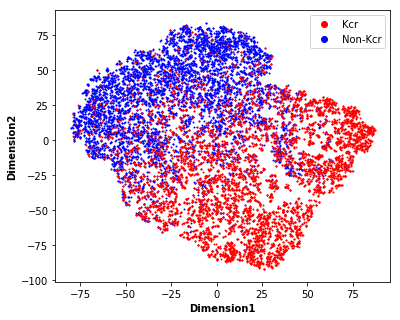

In [43]:
capsul_feature=plt.figure(figsize=(6,5))
for i, labels in enumerate(training_label):
    #if int(labels)==0:
    if int(np.argmax(labels))==0:
        plt.scatter(embedded[i,0],embedded[i,1],c='r',s=0.9,facecolors='none',label='Non-KCR')
    else:
        plt.scatter(embedded[i,0],embedded[i,1],c='b',s=0.9,facecolors='none',label='KCR')
plt.ylabel('Dimension2',fontweight='bold')
plt.xlabel('Dimension1',fontweight='bold')
l1=plt.Line2D(range(0),range(0),marker='o',color='r',linestyle='')
l2=plt.Line2D(range(0),range(0),marker='o',color='b',linestyle='')
plt.legend((l1,l2),('Kcr','Non-Kcr'),loc='upper right',numpoints=1)
#capsul_feature.savefig('t-SNE_capsul_ind_independent_KcrCaps.pdf') for saving figure
plt.show()
